# This notebook is designed for teaching/testing purposes to help you visualize the tensor shapes that go through each module

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg)
print(tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = 512) # assuming 'bpe_tinyStories', size options are 512, 1024 and 2048

import random
import torch

ModelConfig(dim=4, device='mps', linear_bias=False, out_weight_share=True, max_seq_len=7, pos_enc_type='RoPE', theta=10000, tokenizer='bpe_tinyStories', vocab_len=2048, num_layers=2, second_resid_norm=False, mlp_hidden_mult=2, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=2, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06)
TrainConfig(model_name='2024-10-08|23-33-49', dataset_name='noanabeshima/TinyStoriesV2', data_subset=None, streaming=False, micro_batch_size=3, grad_accum_steps=2, max_iters=20, eval_interval=2, eval_samples=1, checkpoint_interval=None, beta1=0.9, beta2=0.95, epsilon=1e-08, weight_decay=0.05, grad_clip=1.0, lr_init=1e-06, lr_max=0.01, lr_min=0.0001, warmup_iters=2, final_flat_iters=1, anneal_type='cos', num_restarts=0, T_mult=2)


/Users/evintunador/Documents/repos/templateGPT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Norms

In [3]:
from modules.norm import Norm

# Create an instance of RMSNorm
module = Norm(cfg.dim, 'RMSNorm', device=cfg.device)

# let's take a look
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

# you can also have it optionally print out all tensors in full
module.enable_full_tensor_printing()
# i recommend only doing this when you have very small toy values for your hyperparameters, 
# otherwise the tensors are too big to view & the logs will take up too much space

### Optionally disabling printing for sub-functions
#module.disable_function_logging('CosineNorm')
#module.disable_function_logging('LayerNorm')
#module.disable_function_logging('RMSNorm')

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x)

# Disable logging. 
# This isn't actually necessary since we won't be using this object again but that's how you'd do it
module.disable_logging()

# clearing up ram jic we're training later
del module, x, output

number of parameters: 0.00K
Norm()

====================Entering Norm.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -1.961/2.597
Full tensor content:
tensor([[[ 0.2459, -1.1636, -1.5237, -0.0737],
         [-0.0474, -0.6543, -1.2353,  0.2606],
         [ 0.0069, -0.5266, -0.1695,  1.8770],
         [-0.4793, -0.0390,  0.5932, -1.4256],
         [-0.3897, -1.4554,  0.3027, -0.6638],
         [ 1.9692,  0.6627, -1.6528,  0.1878],
         [ 2.5975, -0.3696, -1.2976,  0.8763]],

        [[-0.3245,  1.5467, -0.8764, -0.1252],
         [-1.9105,  1.6103, -0.9344,  1.4153],
         [-0.6104,  0.7250, -0.7719, -0.5431],
         [-0.3343, -1.6637,  0.5672,  1.1532],
         [ 0.3524, -0.9687, -0.7320,  0.1167],
         [-0.0590,  0.1654,  0.5599,  2.2032],
         [ 0.5050, -0.2919,  1.8451,  0.2176]],

        [[-0.1951, -1.8131, -0.9637,  0.2789],
         [ 1.0429, -0.3519,  0.2467, -0.0979],
         [ 1.4257

# Attention

In [6]:
from modules.attention import SelfAttention, PrecomputeRotaryFrequencies

## training

In [7]:
%%time

# first up let's look at training

# Create an instance of multi-head self-attention
module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('splice_specific_frequencies')
#module.disable_function_logging('apply_rotary_pos_emb')
#module.disable_function_logging('rotate_half')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('flash_attention')
#module.disable_function_logging('regular_attention')
#module.disable_function_logging('adjust_inference_mask')
#module.disable_function_logging('project_values')

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x, freqs, mask, training=True)

# clearing up ram jic we're training later
del module, precompute_freqs, freqs, mask, x, output

number of parameters: 0.05K
SelfAttention(
  (Wq): Linear(in_features=4, out_features=4, bias=False)
  (Wk): Linear(in_features=4, out_features=2, bias=False)
  (Wv): Linear(in_features=4, out_features=2, bias=False)
  (Wo): Linear(in_features=4, out_features=4, bias=False)
)

====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.368/2.264
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.990/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.959/0.909
Tensor 'mask' shape: torch.Size([7, 7]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
bool 'training': Value=True

====================Entering SelfAttention.apply_rotary_pos_emb====================
Inputs:
Tensor 'q' shape: torch.Size([3, 7, 2, 2]), dtype: torch.float32, device: mps:0,

## inference 

In [8]:
%%time

module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('splice_specific_frequencies')
#module.disable_function_logging('apply_rotary_pos_emb')
#module.disable_function_logging('rotate_half')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('flash_attention')
#module.disable_function_logging('regular_attention')
#module.disable_function_logging('adjust_inference_mask')
#module.disable_function_logging('project_values')

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len // 2,cfg.dim).to(cfg.device) 

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None

mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
mask = mask[:cfg.max_seq_len//2, :cfg.max_seq_len//2]
print('mask:\n', mask)

# Call the forward method - logging will occur
output = module(x, freqs, mask)
print(output)
    
# clearing up ram jic we're training later
del module, x, precompute_freqs, freqs, mask, output

mask:
 tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]], device='mps:0')

====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 3, 4]), dtype: torch.float32, device: mps:0, min/max: -2.409/2.992
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.990/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.959/0.909
Tensor 'mask' shape: torch.Size([3, 3]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
bool 'training': Value=False

====================Entering SelfAttention.apply_rotary_pos_emb====================
Inputs:
Tensor 'q' shape: torch.Size([3, 3, 2, 2]), dtype: torch.float32, device: mps:0, min/max: -1.443/1.428
Tensor 'k' shape: torch.Size([3, 3, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -1.044/1.459
Tensor 'sin' shape: torch.Size([1

# Multi-Layer Perceptron

In [9]:
from modules.mlp import MLP

In [10]:
%%time

# GeGLU
module = MLP(
    cfg.dim, 
    int(cfg.dim * cfg.mlp_hidden_mult * 2/3), 
    cfg.dim, 
    'GeLU', 
    gated=True, 
    bias=cfg.linear_bias, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 0.06K
MLP(
  (Wup): Linear(in_features=4, out_features=5, bias=False)
  (Wgate): Linear(in_features=4, out_features=5, bias=False)
  (Wdown): Linear(in_features=5, out_features=4, bias=False)
  (nonlinearity): GELU(approximate='none')
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.464/2.680
bool 'training': Value=True

====================Entering MLP.up_proj====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.464/2.680

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 5]), dtype: torch.float32, device: mps:0, min/max: -1.722/2.098
====================Exiting MLP.up_proj====================

====================Entering MLP.gate_proj====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.464/2.680

Outputs:
Tensor 'output' 

In [11]:
%%time

# not gated and testing a different nonlinearity
module = MLP(
    cfg.dim, 
    cfg.dim * cfg.mlp_hidden_mult, 
    cfg.dim, 
    'ReLU', 
    gated=False, 
    bias=True, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 0.08K
MLP(
  (Wup): Linear(in_features=4, out_features=8, bias=True)
  (Wdown): Linear(in_features=8, out_features=4, bias=True)
  (nonlinearity): ReLU()
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.988/2.564
bool 'training': Value=True

====================Entering MLP.up_proj====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.988/2.564

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 8]), dtype: torch.float32, device: mps:0, min/max: -1.527/1.996
====================Exiting MLP.up_proj====================

====================Entering MLP.down_proj====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 8]), dtype: torch.float32, device: mps:0, min/max: -1.696/2.217

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -1.04

# ResidualLayer

In [12]:
from modules.layer import Layer

## training

In [13]:
%%time

# TRAINING
module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()
### Optionally disabling printing for sub-modules
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')

### Optionally disabling printing for sub-functions
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
print(mask)
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

output = module(x, freqs, mask, training=True)
module.disable_logging()
del module,freqs, mask, x, output

number of parameters: 0.12K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=4, out_features=4, bias=False)
    (Wk): Linear(in_features=4, out_features=2, bias=False)
    (Wv): Linear(in_features=4, out_features=2, bias=False)
    (Wo): Linear(in_features=4, out_features=4, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=4, out_features=5, bias=False)
    (Wgate): Linear(in_features=4, out_features=5, bias=False)
    (Wdown): Linear(in_features=5, out_features=4, bias=False)
    (nonlinearity): SiLU()
  )
)
tensor([[ True, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True]

## inference

In [14]:
%%time

# now let's do it for INFERENCE with the full kv-caching process 
    # meaning initial variable length prompts AND successive auto-regressive single-token input
# here we'll be pretending we're using a model that's just a single transformer block (resid, attn, mlp) called recurrently

module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()

### Optionally disabling printing for sub-modules
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')

### Optionally disabling printing for sub-functions
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len // 2,cfg.dim).to(cfg.device)

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None

mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
mask = mask[:cfg.max_seq_len//2, :cfg.max_seq_len//2]
print('mask:\n', mask)

# Call the forward method - logging will occur
output = module(x, freqs, mask)
print(output)

del module, x, precompute_freqs, freqs, mask, output

number of parameters: 0.12K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=4, out_features=4, bias=False)
    (Wk): Linear(in_features=4, out_features=2, bias=False)
    (Wv): Linear(in_features=4, out_features=2, bias=False)
    (Wo): Linear(in_features=4, out_features=4, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=4, out_features=5, bias=False)
    (Wgate): Linear(in_features=4, out_features=5, bias=False)
    (Wdown): Linear(in_features=5, out_features=4, bias=False)
    (nonlinearity): SiLU()
  )
)
mask:
 tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]], device='mps:0')

====================Entering Layer.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 3, 4]), dtype: torch.float32, device: mps:0, min/max: -2.394/2.568
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.99

# Full Model

In [15]:
from modules.model import Model
from inference import sampler

## training

In [16]:
%%time

# TRAINING
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#module.precompute_freqs.enable_logging() # only un-comment this line if using RoPE
#module.layers[0].enable_logging()
for i in range(cfg.num_layers):
    module.layers[i].enable_logging()
module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)
target_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)

output, loss = module(input_token_ids, target_token_ids)
print(output, '\n', loss)
del module, input_token_ids, target_token_ids, output, loss

number of parameters: 0.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 4)
  (layers): ModuleList(
    (0-1): 2 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=4, out_features=4, bias=False)
        (Wk): Linear(in_features=4, out_features=2, bias=False)
        (Wv): Linear(in_features=4, out_features=2, bias=False)
        (Wo): Linear(in_features=4, out_features=4, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=4, out_features=5, bias=False)
        (Wgate): Linear(in_features=4, out_features=5, bias=False)
        (Wdown): Linear(in_features=5, out_features=4, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=4, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)

====================Entering Model.forward====================
Inputs:
Tensor 'input_

## inference

In [17]:
%%time

# Inference
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#for i in range(cfg.num_layers):
    #module.layers[i].enable_logging()
#module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len // 2)).to(cfg.device)

logits, _ = module(input_token_ids)
print(f'logits: {logits.shape}')
next_token_batch = sampler(logits)
print(f'next_token_batch: {next_token_batch}')
input_token_ids = torch.concat([input_token_ids, next_token_batch], dim=1)
print(f'input_token_ids: {input_token_ids}')

del module, input_token_ids, logits, next_token_batch

number of parameters: 0.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 4)
  (layers): ModuleList(
    (0-1): 2 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=4, out_features=4, bias=False)
        (Wk): Linear(in_features=4, out_features=2, bias=False)
        (Wv): Linear(in_features=4, out_features=2, bias=False)
        (Wo): Linear(in_features=4, out_features=4, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=4, out_features=5, bias=False)
        (Wgate): Linear(in_features=4, out_features=5, bias=False)
        (Wdown): Linear(in_features=5, out_features=4, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=4, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)

====================Entering Model.forward====================
Inputs:
Tensor 'input_

# Other fun stuff

### Learning Rate Schedule Display
thought i'd make somewhere to help you visualize what the learning rate schedule settings you've got look like

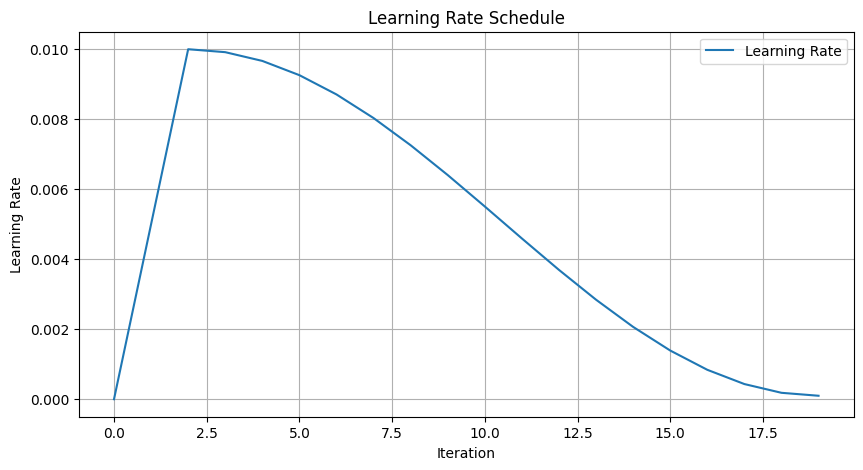

In [18]:
import matplotlib.pyplot as plt
from train import scheduler_lambda
from config import TrainConfig
tcfg = TrainConfig()
    
# Generate learning rate values
lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
# Plot the learning rates
plt.figure(figsize=(10, 5))
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
plt.show()

### visualizing our tokenizer

In [20]:
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = cfg.vocab_len)
prompt = 'Once upon a time, there was a boy named Tim.'
tokenizer.display(prompt)

['Once',
 ' upon',
 ' a',
 ' time',
 ',',
 ' there',
 ' was',
 ' a',
 ' boy',
 ' named',
 ' Tim',
 '.']